# 3. Visualisation des données

Dans cette partie du projet, nous utilisons les **tags associés aux images** pour créer des **graphiques** qui mettent en évidence les différences et caractéristiques principales des images sélectionnées.

Ces visualisations permettent d’avoir une vue d’ensemble sur :
- La répartition des tags (ex. nature, eau, animaux, etc.)
- Les tailles ou orientations des images
- La fréquence d’utilisation de certains appareils ou dates de prise de vue


###     A. Nombre d’images par année

On peut remarquer que la majorité des images ont été prises entre **2022** et **2024**.


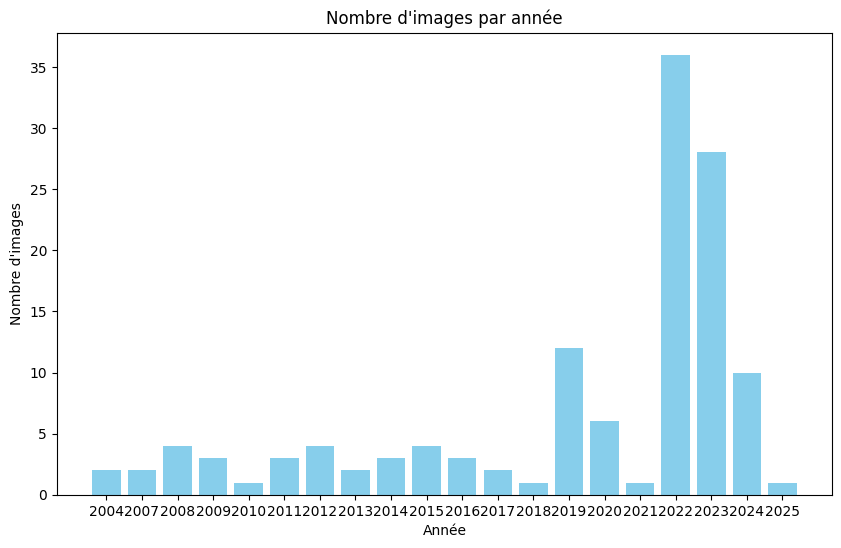

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Extraction de l'année à partir d'une chaîne de date EXIF (format "YYYY:MM:DD HH:MM:SS")
def parse_year(date_str):
    try:
        year = date_str.split(':')[0]
        return int(year)
    except Exception:
        return None


def visualize_images_per_year(annotations):
    years = []
    for ann in annotations:
        date_creation = ann.get("date_creation")
        if date_creation:
            year = parse_year(date_creation)
            if year:
                years.append(year)
    if years:
        year_counts = Counter(years)
        sorted_years = sorted(year_counts.items())
        x = [str(year) for year, count in sorted_years]
        y = [count for year, count in sorted_years]
        plt.figure(figsize=(10, 6))
        plt.bar(x, y, color='skyblue')
        plt.xlabel("Année")
        plt.ylabel("Nombre d'images")
        plt.title("Nombre d'images par année")
        plt.show()
    else:
        print("Aucune information de date n'est disponible pour les images.")

# Charger les annotations (supposées être enregistrées dans "annotations.json")
annotations = []
with open("/data/annotations.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        annotations.append(json.loads(line))

visualize_images_per_year(annotations)


### B. Répartition des images par taille

On peut remarquer que la majorité des images sont des images **extra-larges**.


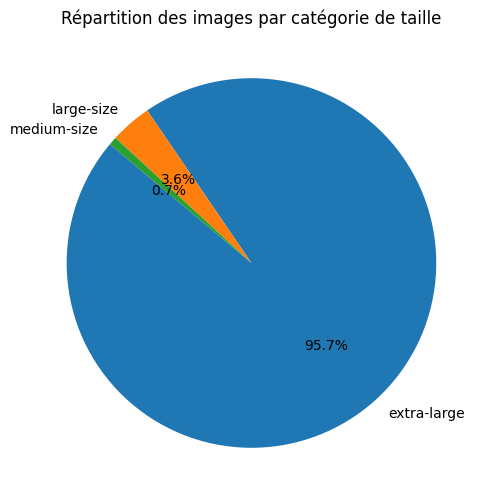

In [6]:
def visualize_size_distribution(annotations):
    sizes = []
    for ann in annotations:
        taille = ann.get("taille_image", {})
        sizes.append(taille)
    size_counts = Counter(sizes)
    labels = list(size_counts.keys())
    counts = list(size_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition des images par catégorie de taille")
    plt.show()

visualize_size_distribution(annotations)

### C. Repartition des images par orientation

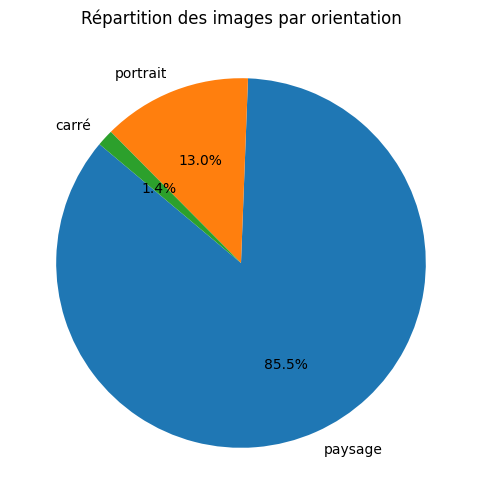

In [7]:
def visualize_orientation_distribution(annotations):
    orientations = [ann.get("orientation", "Inconnue") for ann in annotations]
    orientation_counts = Counter(orientations)
    labels = list(orientation_counts.keys())
    counts = list(orientation_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition des images par orientation")
    plt.show()

visualize_orientation_distribution(annotations)

### D. Repartition des couleurs préféré

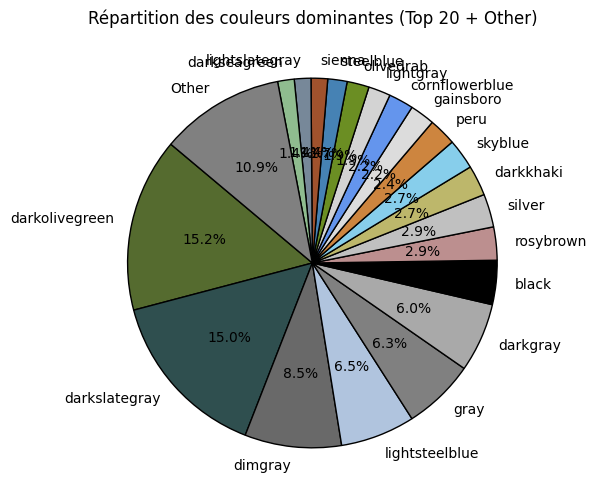

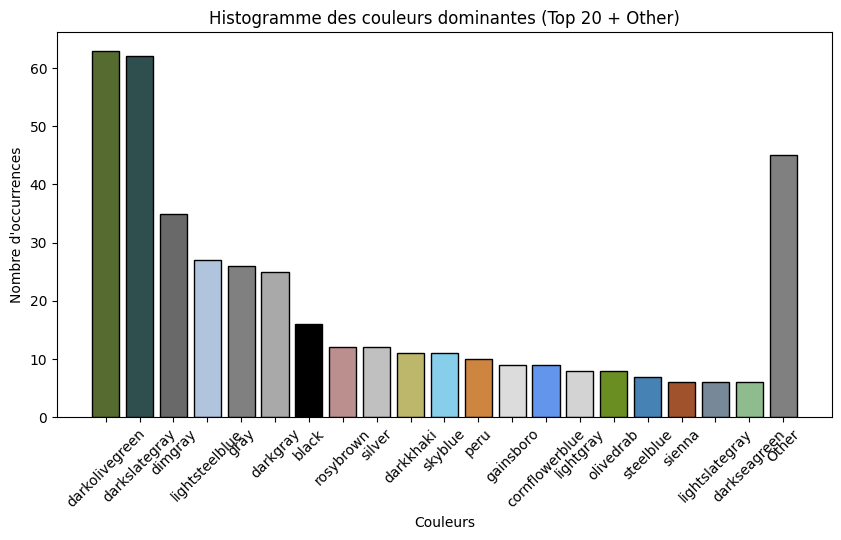

In [8]:
def visualize_couleurs_preferere(annotations):
    couleurs = []

    # Extraction correcte des couleurs dominantes
    for ann in annotations:
        if "couleurs_dominantes" in ann:
            couleurs.extend(ann["couleurs_dominantes"])  # Ajout direct des couleurs

    # Comptage des occurrences des couleurs
    clr_counts = Counter(couleurs)

    # Trier les couleurs par fréquence (décroissante)
    sorted_colors = clr_counts.most_common(20)  # Top 20 couleurs
    top_colors = {color: count for color, count in sorted_colors}

    # Regrouper les autres couleurs sous "Other"
    other_count = sum(count for color, count in clr_counts.items() if color not in top_colors)
    if other_count > 0:
        top_colors["Other"] = other_count  # Ajouter la catégorie Other

    # Préparer les données pour les graphiques
    labels = list(top_colors.keys())
    counts = list(top_colors.values())

    # Utilisation des couleurs réelles pour les 20 couleurs, et gris pour "Other"
    color_palette = labels[:-1] + ["gray"]  # "Other" en gris

    #  Graphique Donut (Camembert)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=color_palette, wedgeprops={'edgecolor': 'black'})
    plt.title("Répartition des couleurs dominantes (Top 20 + Other)")
    plt.show()

    # Histogramme des couleurs dominantes
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color=color_palette, edgecolor='black')
    plt.xlabel("Couleurs")
    plt.ylabel("Nombre d'occurrences")
    plt.title("Histogramme des couleurs dominantes (Top 20 + Other)")
    plt.xticks(rotation=45)  # Rotation pour une meilleure lisibilité
    plt.show()

visualize_couleurs_preferere(annotations)


### E. Tags dominants des images

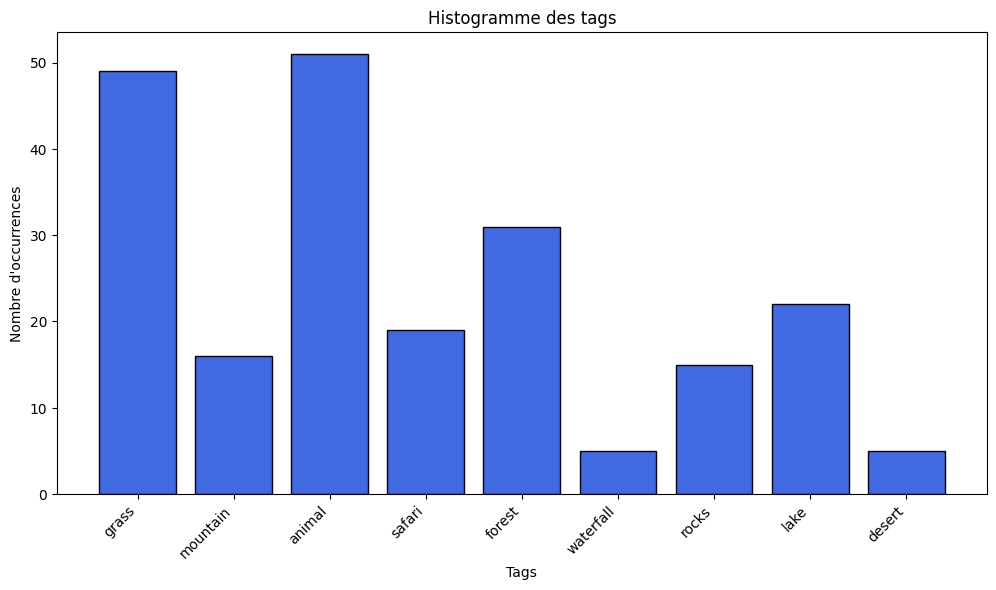

In [9]:
def visualize_tags(annotations):
    
    tags = []

    # Extraction des tags
    for ann in annotations:
        if "tags" in ann:
            tags.extend(ann["tags"])  # Ajout de tous les tags dans la liste

    # Comptage des occurrences des tags
    tag_counts = Counter(tags)
    labels = list(tag_counts.keys())
    counts = list(tag_counts.values())

    # Histogramme des tags
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color="royalblue", edgecolor="black")
    plt.xlabel("Tags")
    plt.ylabel("Nombre d'occurrences")
    plt.title("Histogramme des tags")
    plt.xticks(rotation=45, ha="right")  # Rotation des labels pour lisibilité
    plt.show()

visualize_tags(annotations)

### F. Marque de l'appreil

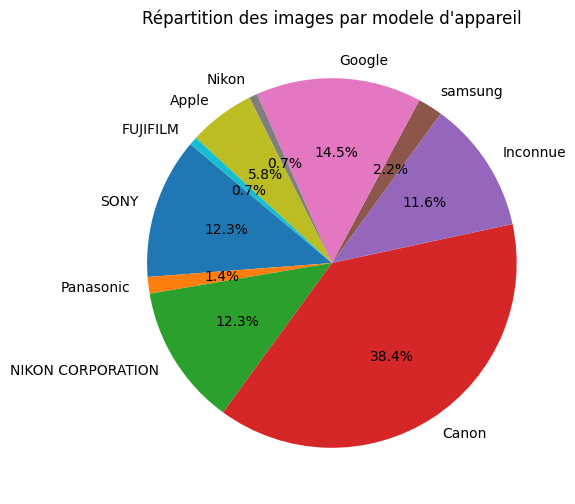

In [10]:
def visualize_modele_appareil(annotations):
    modele = [ann.get("modele_appareil", "Inconnue") for ann in annotations]
    modele_counts = Counter(modele)
    labels = list(modele_counts.keys())
    counts = list(modele_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition des images par modele d'appareil")
    plt.show()

visualize_modele_appareil(annotations)

## Afficher les images utilisateur 

Affichage de 5 images préférées de l'utilisateur 1


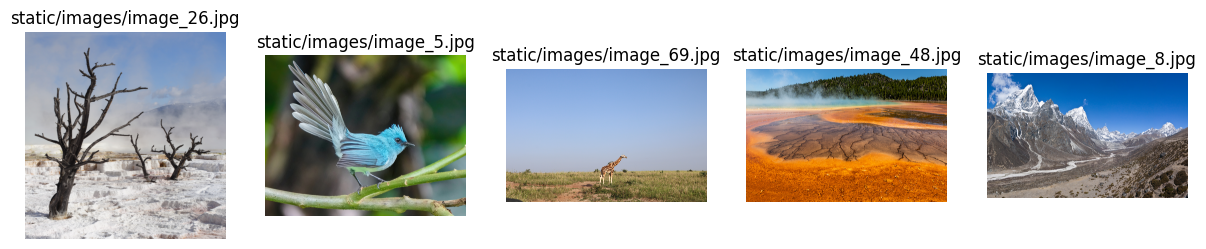

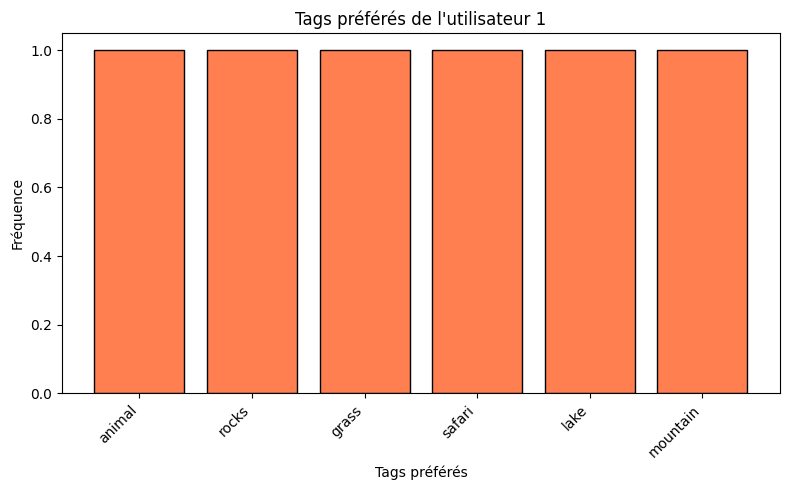

In [ ]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import math
from collections import Counter

def visualize_tags(user_id):
    """Affiche les tags préférés d'un utilisateur sous forme d'histogramme."""
    
    with open("/data/user_profiles.json", "r", encoding="utf-8") as f:
        user_profiles = json.load(f)

    if str(user_id) not in user_profiles:
        print(f"Utilisateur {user_id} non trouvé.")
        return

    tags = user_profiles[str(user_id)].get("preferred_tags", [])

    if not tags:
        print(f"Aucun tag préféré trouvé pour l'utilisateur {user_id}.")
        return

    tag_counts = Counter(tags)
    labels = list(tag_counts.keys())
    counts = list(tag_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color="coral", edgecolor="black")
    plt.xlabel("Tags préférés")
    plt.ylabel("Fréquence")
    plt.title(f"Tags préférés de l'utilisateur {user_id}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




def show_favorite_images(user_id, image_folder=""):
    """Affiche toutes les images préférées d'un utilisateur."""
    
    # Charger les profils utilisateurs
    with open("user_profiles.json", "r", encoding="utf-8") as f:
        user_profiles = json.load(f)

    # Vérifier si l'utilisateur existe
    if str(user_id) not in user_profiles:
        print(f"Utilisateur {user_id} non trouvé.")
        return

    # Récupérer les images préférées
    favorite_files = user_profiles[str(user_id)]["favorite_images"]

    if not favorite_files:
        print(f"Aucun favori trouvé pour l'utilisateur {user_id}.")
        return

    print(f"Affichage de {len(favorite_files)} images préférées de l'utilisateur {user_id}")

    # Définir le nombre de colonnes et de lignes
    num_images = len(favorite_files)
    num_cols = 5  
    num_rows = math.ceil(num_images / num_cols)  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()  

    for i, image_name in enumerate(favorite_files):
        image_path = os.path.join(image_folder, image_name)

        if not os.path.exists(image_path):
            print(f"Image introuvable : {image_path}")
            continue

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(image_name)

    # Cacher les axes inutilisés
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.show()
    # Exemple
    visualize_tags(1)

show_favorite_images(1, image_folder="")
